In [1]:
import torch
import subprocess
import matplotlib.pyplot as plt
import torch.optim as optim
import sounddevice as sd

from torch.utils.data import TensorDataset, DataLoader
from scipy.io.wavfile import write
from typing import List
from dataclasses import dataclass
from scipy.io import loadmat
from tqdm import tqdm
from torch import nn

In [2]:
class Net(nn.Sequential):
    def __init__(
        self,
        input_dim=85,
        hidden_dim=[4],
        activation=nn.ReLU(),
        out_dim=10,
        dropout=0.0,
    ):
        assert len(hidden_dim) > 0, "at least one hidden layer"
        layers = []

        # first layer
        layers.append(nn.Linear(input_dim, hidden_dim[0]))
        layers.append(nn.BatchNorm1d(hidden_dim[0]))

        # dropout
        if dropout > 0.0:
            layers.append(nn.Dropout(dropout))

        # activation
        layers.append(activation)

        # hidden layers
        if len(hidden_dim) > 1:
            for k in range(1, len(hidden_dim)):
                layers.append(nn.Linear(hidden_dim[k - 1], hidden_dim[k]))
                layers.append(nn.BatchNorm1d(hidden_dim[k]))
                layers.append(nn.Dropout(dropout))
                layers.append(activation)

        layers.append(nn.Linear(hidden_dim[-1], out_dim))
        super().__init__(*layers)

In [3]:
def train_epoch(network, loss_fn, dataloader, optimizer, device="cpu"):
    # set the network to train mode
    network.to(device)
    network.train()

    # initialize variables to keep track of loss and number of batches
    epoch_loss = 0.0
    num_batches = 0
    epoch_correct = 0.0
    num_samples = 0

    # iterate over the data loader
    for batch_inputs, batch_targets in dataloader:
        # move data to the appropriate device (e.g., GPU)
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        batch_outputs = network(batch_inputs)

        # compute the loss
        loss = loss_fn(batch_outputs, batch_targets)

        # backward pass
        loss.backward()

        # update the parameters
        optimizer.step()

        # accumulate the loss
        epoch_loss += loss.item()
        num_batches += 1

        # calculate the number of correct predictions in the batch
        _, predicted = torch.max(batch_outputs, 1)
        epoch_correct += (predicted == batch_targets).sum().item()
        num_samples += batch_targets.size(0)

    # calculate the average loss for the epoch
    average_loss = epoch_loss / num_batches

    # calculate the accuracy for the epoch
    accuracy = epoch_correct / num_samples

    return average_loss, accuracy

In [4]:
def validate_epoch(network, loss_fn, dataloader, device="cpu"):
    # Set the network to evaluation mode
    network.to(device)
    network.eval()

    # Initialize variables to keep track of loss and number of batches
    epoch_loss = 0.0
    num_batches = 0
    epoch_correct = 0.0
    num_samples = 0

    # Turn off gradients
    with torch.no_grad():
        # Iterate over the data loader
        for batch_inputs, batch_targets in dataloader:
            # Move data to the appropriate device (e.g., GPU)
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            # Forward pass
            batch_outputs = network(batch_inputs)

            # Compute the loss
            loss = loss_fn(batch_outputs, batch_targets)

            # Accumulate the loss
            epoch_loss += loss.item()
            num_batches += 1

            # Calculate the number of correct predictions in the batch
            _, predicted = torch.max(batch_outputs, 1)
            epoch_correct += (predicted == batch_targets).sum().item()
            num_samples += batch_targets.size(0)

    # Calculate the average loss for the epoch
    average_loss = epoch_loss / num_batches

    # Calculate the accuracy for the epoch
    accuracy = epoch_correct / num_samples

    return average_loss, accuracy

In [5]:
def train(
    network,
    loss_fn,
    train_dataloader,
    val_dataloader,
    optimizer,
    num_epochs,
    device="cpu",
):
    train_losses = []
    val_losses = []
    val_acc = []
    train_acc = []

    # Initialize tqdm for progress tracking
    progress_bar = tqdm(range(num_epochs), desc="Training Progress")

    for _ in progress_bar:
        # Training phase
        train_loss, train_accuracy = train_epoch(
            network, loss_fn, train_dataloader, optimizer, device=device
        )
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)

        # Validation phase
        val_loss, val_accuracy = validate_epoch(
            network, loss_fn, val_dataloader, device=device
        )
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        # Update tqdm progress bar
        progress_bar.set_postfix(
            {
                "Train Loss": train_loss,
                "Val Loss": val_loss,
                "Train Acc": train_accuracy,
                "Val Acc": val_accuracy,
            }
        )

    return train_losses, val_losses, train_acc, val_acc

Primero cargamos los datos de entrenamiento y de validación, los normalizamos y creamos los datasets correspondientes.

In [6]:
# load the dataset
dataset_train = loadmat("training_data.mat")
dataset_validation = loadmat("validation_data.mat")

# extract the training and validation data
x_train = dataset_train["features_train"]
y_train = dataset_train["labels_train_int"].flatten()
x_val = dataset_validation["features_validation"]
y_val = dataset_validation["labels_validation_int"].flatten()

x_train_mean = x_train.mean(axis=0, keepdims=True)
x_train_std = x_train.std(axis=0, keepdims=True)

x_train_norm = (x_train - x_train_mean) / x_train_std
x_val_norm = (x_val - x_train_mean) / x_train_std

# convert lists to tensors
x_train_tensor = torch.tensor(x_train_norm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = torch.tensor(x_val_norm, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# create TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

Vamos a definir una función para crear nuestra red dados unos parametros, ya que vamos a ir creando varias redes para probar distintas configuraciones de los parametros de la red.

In [7]:
@dataclass
class NetParams:
    learning_rate: float
    batch_size: int
    num_epochs: int
    hidden_dim: List[int]
    activation: nn.Module
    dropout: float


def create_net(net_params: NetParams):
    # define network
    net = Net(
        hidden_dim=net_params.hidden_dim,
        activation=net_params.activation,
        dropout=net_params.dropout,
    )

    # create the optimizer and loss function
    optimizer = optim.SGD(net.parameters(), lr=net_params.learning_rate, momentum=0.85)
    loss_fn = nn.CrossEntropyLoss()

    # create the data loaders
    train_dataloader = DataLoader(
        train_dataset, batch_size=net_params.batch_size, shuffle=True
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=net_params.batch_size, shuffle=False
    )

    # train the net
    train_losses, val_losses, train_acc, val_acc = train(
        net,
        loss_fn,
        train_dataloader,
        val_dataloader,
        optimizer,
        net_params.num_epochs,
        device="cpu",
    )

    print(
        f"Best validation accuracy: {max(val_acc) * 100:.2f}% in epoch {val_acc.index(max(val_acc)) + 1}"
    )

    print(f"Last validation accuracy: {val_acc[-1] * 100:.2f}%")

    # plot the results
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(train_acc, label="train acc")
    ax.plot(val_acc, label="val acc")
    ax.legend()
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    plt.show()

    return net, val_acc[-1]

Creamos nuestra primera red con las siguientes características:
- Optimizador: SGD con momentum ('sgdm')
- Tasa de aprendizaje inicial: 0.01
- Número de épocas: 10
- Tamaño del batch: 512

Training Progress: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s, Train Loss=1.34, Val Loss=1.39, Train Acc=0.516, Val Acc=0.512]


Best validation accuracy: 51.24% in epoch 10
Last validation accuracy: 51.24%


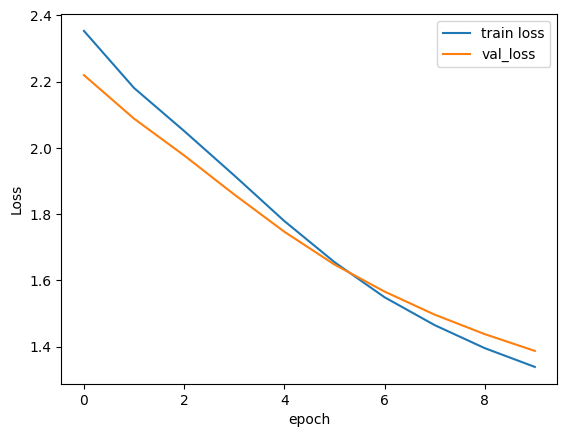

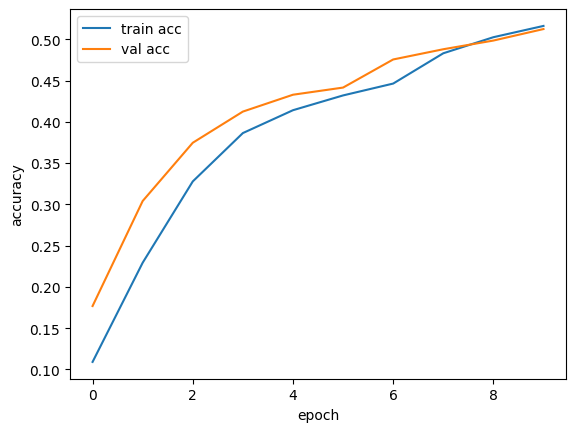

In [8]:
models = []

net_params = NetParams(
    learning_rate=0.01,
    batch_size=512,
    num_epochs=10,
    hidden_dim=[4],
    activation=nn.ReLU(),
    dropout=0.0,
)

net, val_accuracy = create_net(net_params)
models.append((net, val_accuracy, net_params))

Ahora vamos a probar subiendo el learning rate a 10. Vemos como la accuracy pasa a ser del 10%, el peor resultado que se puede conseguir como si la red estuviera clasificando los números aleatoriamente.

Training Progress: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s, Train Loss=2.35, Val Loss=2.41, Train Acc=0.0985, Val Acc=0.0994]


Best validation accuracy: 10.03% in epoch 2
Last validation accuracy: 9.94%


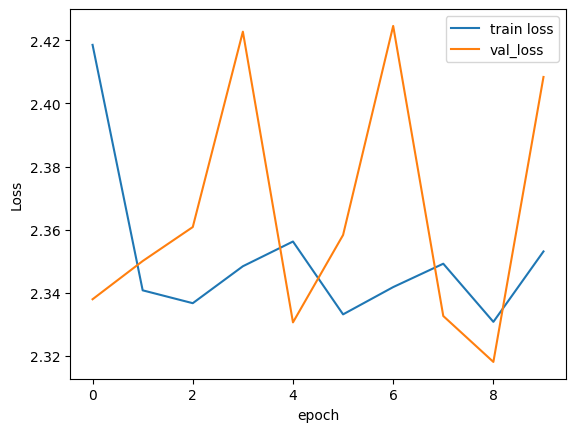

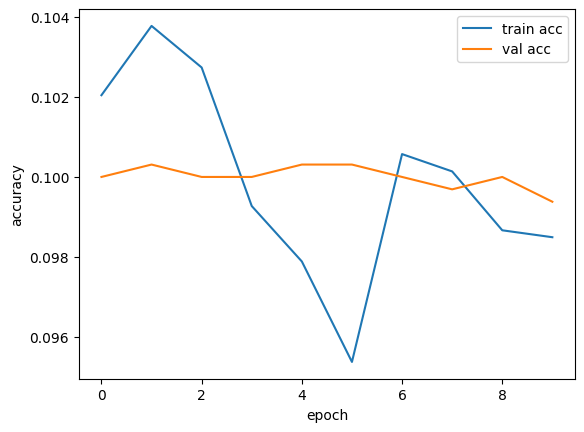

In [9]:
net_params = NetParams(
    learning_rate=10,
    batch_size=512,
    num_epochs=10,
    hidden_dim=[4],
    activation=nn.ReLU(),
    dropout=0.0,
)

net, val_accuracy = create_net(net_params)
models.append((net, val_accuracy, net_params))

Volviendo a poner el learning rate a 0.01 y subiendo el número de epocas a 100 conseguimos elevar el accuracy del modelo.

Training Progress: 100%|██████████| 100/100 [00:12<00:00,  8.23it/s, Train Loss=0.64, Val Loss=0.762, Train Acc=0.789, Val Acc=0.739]


Best validation accuracy: 73.93% in epoch 99
Last validation accuracy: 73.93%


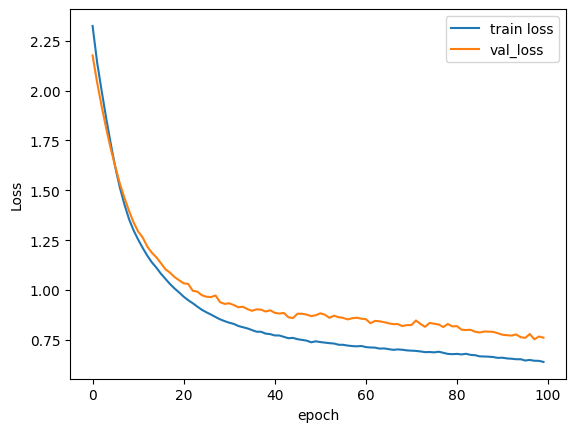

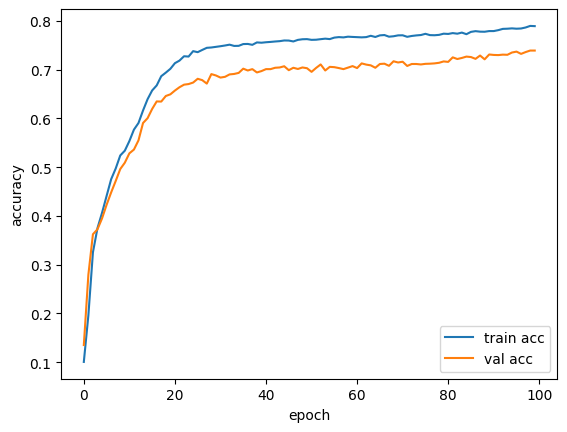

In [10]:
net_params = NetParams(
    learning_rate=0.01,
    batch_size=512,
    num_epochs=100,
    hidden_dim=[4],
    activation=nn.ReLU(),
    dropout=0.0,
)

net, val_accuracy = create_net(net_params)
models.append((net, val_accuracy, net_params))

Ahora al reducir las épocas a 70 conseguimos una accuracy similar. En cuanto al tiempo de entrenamiento a disminuido respecto al del modelo anterior.

Training Progress: 100%|██████████| 70/70 [00:08<00:00,  8.58it/s, Train Loss=0.603, Val Loss=0.719, Train Acc=0.811, Val Acc=0.757]


Best validation accuracy: 75.67% in epoch 70
Last validation accuracy: 75.67%


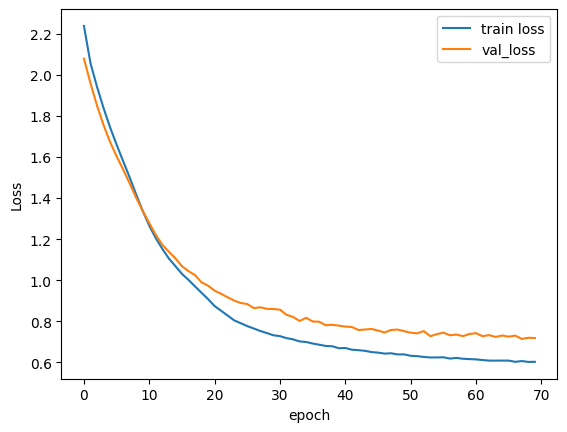

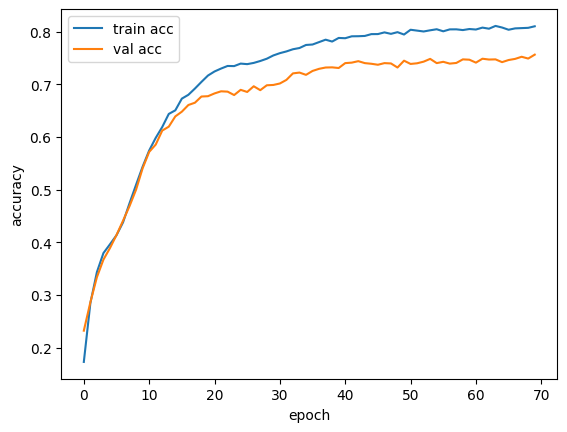

In [11]:
net_params = NetParams(
    learning_rate=0.01,
    batch_size=512,
    num_epochs=70,
    hidden_dim=[4],
    activation=nn.ReLU(),
    dropout=0.0,
)

net, val_accuracy = create_net(net_params)
models.append((net, val_accuracy, net_params))

Al reducir el tamaño del batch el accuracy aumenta al igual que el tiempo de entrenamiento del modelo.

Training Progress: 100%|██████████| 70/70 [00:16<00:00,  4.13it/s, Train Loss=0.608, Val Loss=0.691, Train Acc=0.799, Val Acc=0.779]

Best validation accuracy: 77.96% in epoch 60
Last validation accuracy: 77.89%


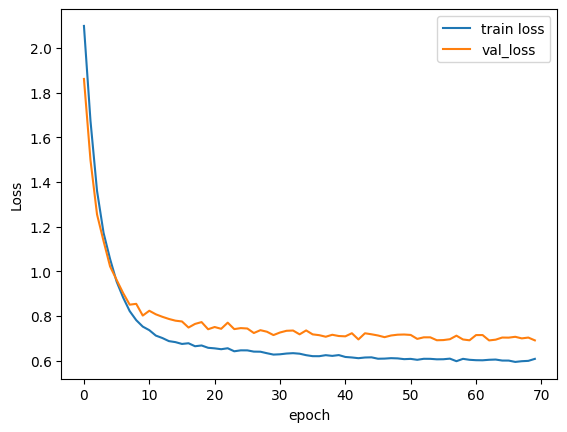

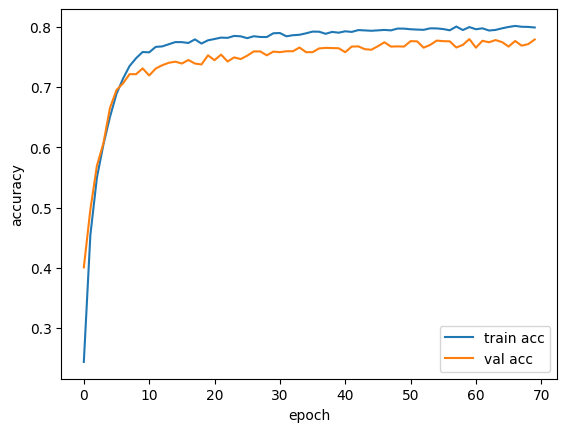

In [12]:
net_params = NetParams(
    learning_rate=0.01,
    batch_size=128,
    num_epochs=70,
    hidden_dim=[4],
    activation=nn.ReLU(),
    dropout=0.0,
)

net, val_accuracy = create_net(net_params)
models.append((net, val_accuracy, net_params))

Cuando aumentamos el tamaño del batch el tiempo de entrenamiento se ver reducido y la accuracy baja un poco ya que la red no tiene el suficiente número de épocas para entrenar.

Training Progress: 100%|██████████| 70/70 [00:07<00:00,  8.86it/s, Train Loss=0.762, Val Loss=0.929, Train Acc=0.759, Val Acc=0.738]


Best validation accuracy: 73.81% in epoch 70
Last validation accuracy: 73.81%


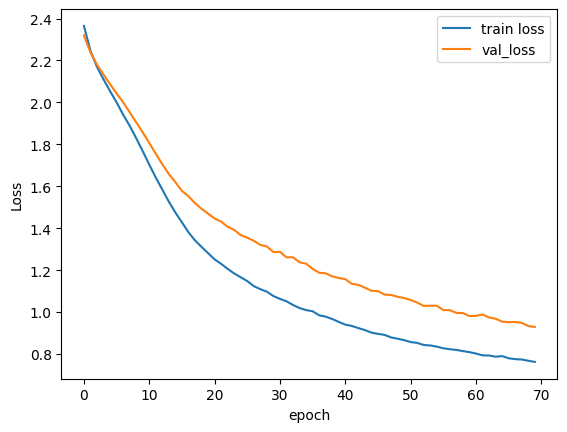

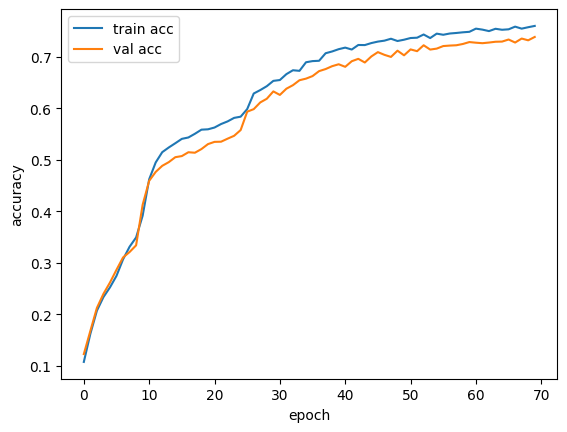

In [13]:
net_params = NetParams(
    learning_rate=0.01,
    batch_size=1024,
    num_epochs=70,
    hidden_dim=[4],
    activation=nn.ReLU(),
    dropout=0.0,
)

net, val_accuracy = create_net(net_params)
models.append((net, val_accuracy, net_params))

Cuando aumentamos el número de épocas aumenta también el tiempo de entrenamiento pero conseguimos una accuracy mayor.

Training Progress: 100%|██████████| 150/150 [00:16<00:00,  9.05it/s, Train Loss=0.643, Val Loss=0.75, Train Acc=0.787, Val Acc=0.752] 

Best validation accuracy: 75.79% in epoch 124
Last validation accuracy: 75.23%


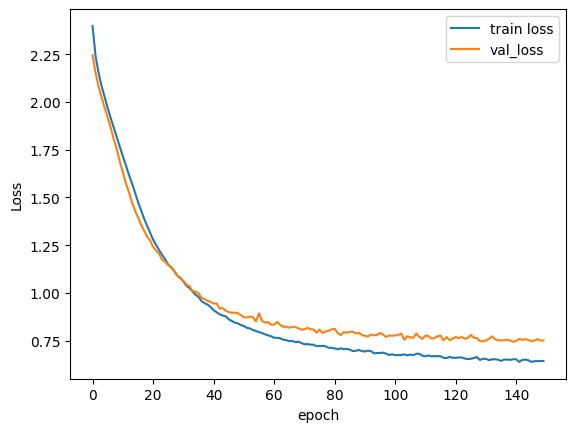

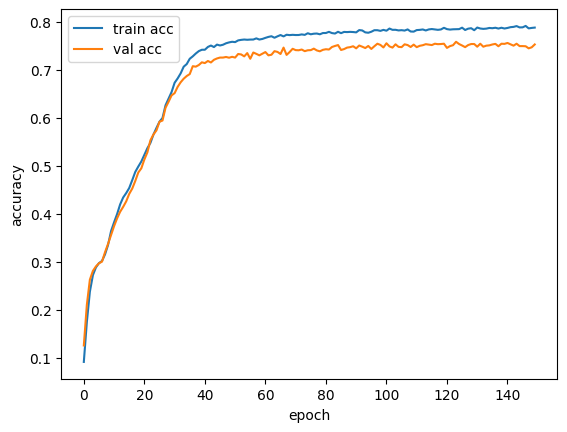

In [14]:
net_params = NetParams(
    learning_rate=0.01,
    batch_size=1024,
    num_epochs=150,
    hidden_dim=[4],
    activation=nn.ReLU(),
    dropout=0.0,
)

net, val_accuracy = create_net(net_params)
models.append((net, val_accuracy, net_params))

Conforme aumentamos el número de capas y el número de neuronas en cada capa el accuracy del modelo va aumentando.

Training Progress: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s, Train Loss=0.7, Val Loss=0.821, Train Acc=0.764, Val Acc=0.713] 


Best validation accuracy: 71.49% in epoch 92
Last validation accuracy: 71.33%


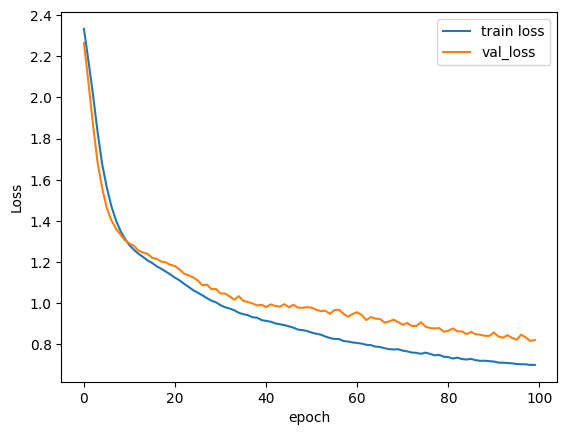

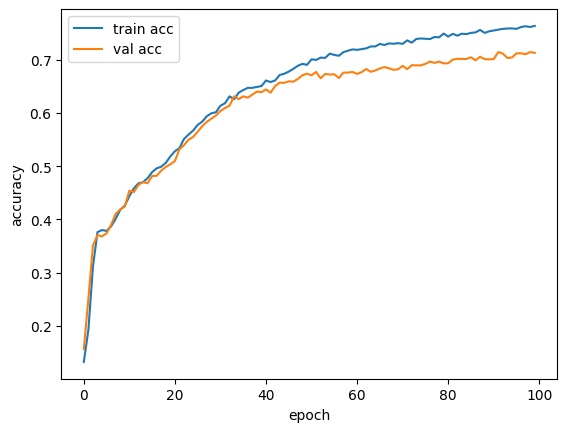

In [15]:
net_params = NetParams(
    learning_rate=0.01,
    batch_size=512,
    num_epochs=100,
    hidden_dim=[4, 4],
    activation=nn.ReLU(),
    dropout=0.0,
)

net, val_accuracy = create_net(net_params)
models.append((net, val_accuracy, net_params))

Training Progress: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s, Train Loss=0.0248, Val Loss=0.524, Train Acc=0.998, Val Acc=0.861]


Best validation accuracy: 87.09% in epoch 43
Last validation accuracy: 86.07%


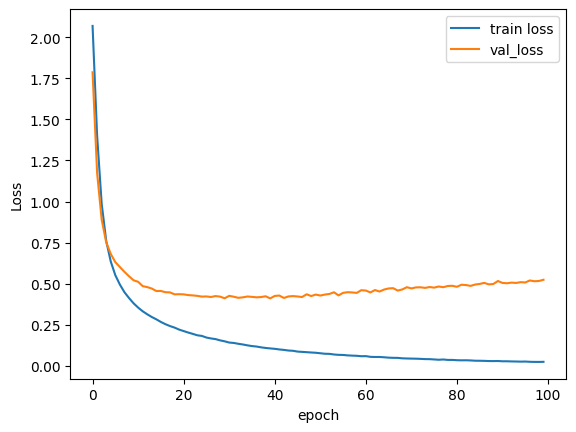

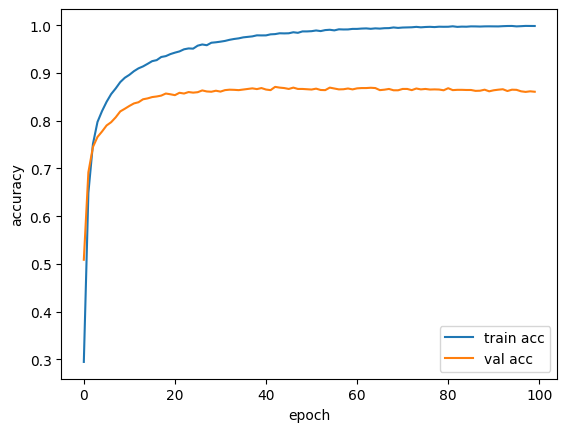

In [16]:
net_params = NetParams(
    learning_rate=0.01,
    batch_size=512,
    num_epochs=100,
    hidden_dim=[128, 128],
    activation=nn.ReLU(),
    dropout=0.0,
)

net, val_accuracy = create_net(net_params)
models.append((net, val_accuracy, net_params))

En la última red podemos ver que la accuracy de entrenamiento acaba siendo del 100% lo que puede ser perjudicial. Para corregir esto añadimos una capa de dropout lo que produce un aumento en el accuracy.

Training Progress: 100%|██████████| 150/150 [00:23<00:00,  6.32it/s, Train Loss=0.159, Val Loss=0.414, Train Acc=0.946, Val Acc=0.877]


Best validation accuracy: 88.20% in epoch 149
Last validation accuracy: 87.74%


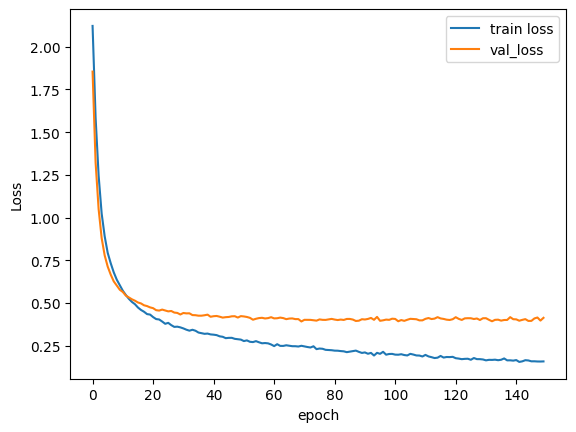

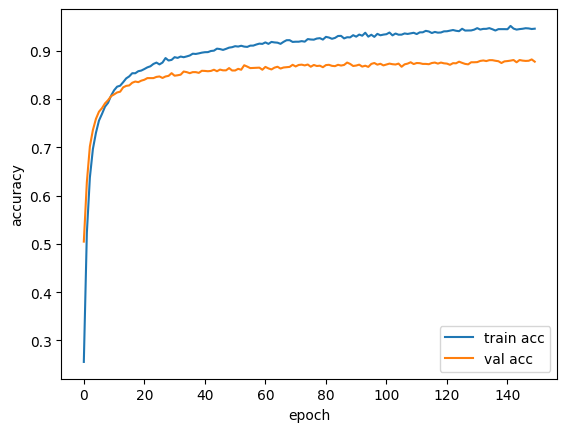

In [17]:
net_params = NetParams(
    learning_rate=0.01,
    batch_size=512,
    num_epochs=150,
    hidden_dim=[128, 128],
    activation=nn.ReLU(),
    dropout=0.25,
)

net, val_accuracy = create_net(net_params)
models.append((net, val_accuracy, net_params))

Ahora vamos a comparar los distintos modelos y cual a sido du accuracy en función de sus parámetros.

In [18]:
# print the nets by accuracy order and their parameters
models.sort(key=lambda x: x[1], reverse=True)
for _, val_accuracy, net_params in models:
    print(f"Validation accuracy: {val_accuracy * 100:.2f}%")
    print(net_params)
    print()

# keep the best model and save it
net = models[0][0]
torch.save(net.state_dict(), "model.pth")

Validation accuracy: 87.74%
NetParams(learning_rate=0.01, batch_size=512, num_epochs=150, hidden_dim=[128, 128], activation=ReLU(), dropout=0.25)

Validation accuracy: 86.07%
NetParams(learning_rate=0.01, batch_size=512, num_epochs=100, hidden_dim=[128, 128], activation=ReLU(), dropout=0.0)

Validation accuracy: 77.89%
NetParams(learning_rate=0.01, batch_size=128, num_epochs=70, hidden_dim=[4], activation=ReLU(), dropout=0.0)

Validation accuracy: 75.67%
NetParams(learning_rate=0.01, batch_size=512, num_epochs=70, hidden_dim=[4], activation=ReLU(), dropout=0.0)

Validation accuracy: 75.23%
NetParams(learning_rate=0.01, batch_size=1024, num_epochs=150, hidden_dim=[4], activation=ReLU(), dropout=0.0)

Validation accuracy: 73.93%
NetParams(learning_rate=0.01, batch_size=512, num_epochs=100, hidden_dim=[4], activation=ReLU(), dropout=0.0)

Validation accuracy: 73.81%
NetParams(learning_rate=0.01, batch_size=1024, num_epochs=70, hidden_dim=[4], activation=ReLU(), dropout=0.0)

Validation ac

Para probar el modelo, dado que la red se ha entrenado con los vectores de features calculados en matlab, voy a calcular en matlab también el vector de features de los audios de prueba, ejecutando un script de matlab desde python. Para probar la red en tiempo real hay que ejecutar esta celda y decir un dígito en los siguientes 3 segundos. Dado que por detras se tiene que iniciar y ejecutar matlab para calcular el vector de features el proceso es un poco lento.

In [23]:
MATLAB_PATH = "/Applications/MATLAB_R2024a.app/bin/matlab"  # path to MATLAB executable(could be different on your machine)
AUDIO_PATH = "spoken_digit.wav"

freq = 16000  # sample rate
duration = 3  # seconds

# record the audio
record = sd.rec(int(duration * freq), samplerate=freq, channels=1)
sd.wait()

# save the audio
write(AUDIO_PATH, 16000, record)

# extract features from the audio file and save it to a .mat file
command = f"{MATLAB_PATH} -batch \"extract_features('{AUDIO_PATH}')\""
subprocess.run(command, shell=True)

# load the audio descriptor
descriptor = loadmat("test_data.mat")["descriptor"]

# normalize the descriptor
descriptor = (descriptor - x_train_mean) / x_train_std

# create a test set
testset = TensorDataset(
    torch.tensor(descriptor, dtype=torch.float32),
)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

# load the trained model
net.load_state_dict(torch.load("model.pth"))
net.eval()

# make the prediction
predictions = []
with torch.no_grad():
    for num in testloader:
        outputs = net(num[0])
        _, predicted = torch.max(outputs, 1)
        prediction = predicted.item()
        predictions.append(prediction)

        predictions_confidence = torch.nn.functional.softmax(outputs, dim=1)
        confidence = torch.max(predictions_confidence)

        print(
            f"Predicted digit: {prediction} with confidence of {confidence * 100:.2f}%"
        )

Predicted digit: 9 with confidence of 73.91%


/bin/sh: /Applications/MATLAB_R2024a.app/bin/matlab: No such file or directory
